In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
%matplotlib inline
# matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

Using TensorFlow backend.


In [2]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [3]:
#Read input image and corresponding mask names
X = sorted(glob('C:/Users/ya-chen.chuang/Documents/QuPath/ProbeSeg/images-new/*.tif'))
Y = sorted(glob('C:/Users/ya-chen.chuang/Documents/QuPath/ProbeSeg/masks-new/*.tif'))


In [4]:
#Read images and masks using their names.
#We are using tifffile library to read images as we have tif images. 
X = list(map(imread,X))
Y = list(map(imread,Y))
# n_channel = 5
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]  #If no third dim. then number of channels = 1. Otherwise get the num channels from the last dim.

In [5]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 18/18 [00:00<00:00, 37.13it/s]


In [6]:
#Split to train and val
#You can use any method to split. I am following the method used in StarDist documentation example
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  18
- training:        15
- validation:       3


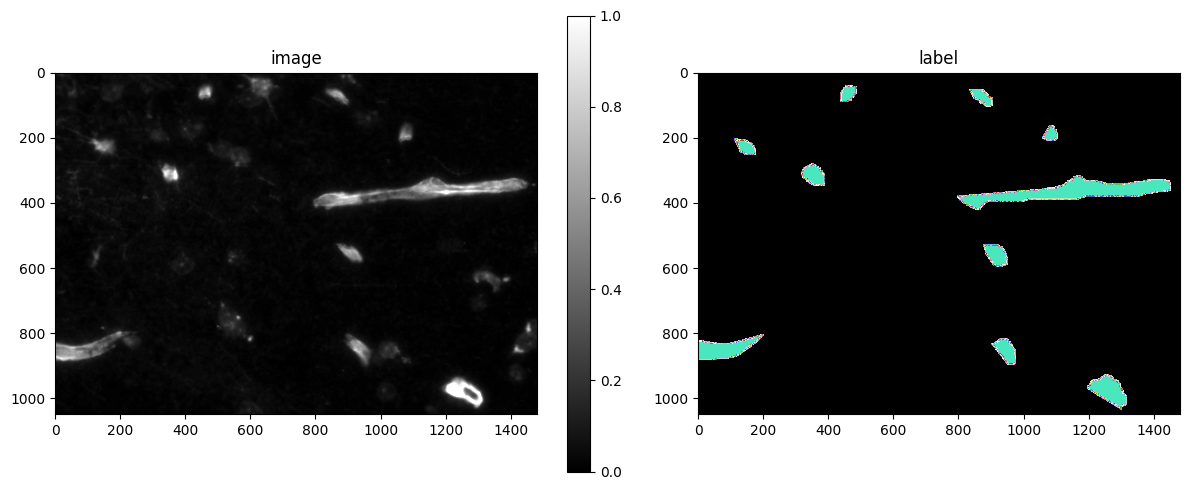

In [20]:
#PLot image and label for some images - sanity check
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()
    
    
i = min(9, len(X)-1)

img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)


In [7]:
#Check config to get an idea about all parameters
print(Config2D.__doc__)


Configuration for a :class:`StarDist2D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    n_rays : int
        Number of radial directions for the star-convex polygon.
        Recommended to use a power of 2 (default: 32).
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
        Overwrite (or add) configuration attributes (see below).


    Attributes
    ----------
    unet_n_depth : int
        Number of U-Net resolution levels (down/up-sampling layers).
    unet_kernel_size : (int,int)
   

In [8]:
#Define the config by setting some parameter values

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32  #Number of radial directions for the star-convex polygon.

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)
print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


In [9]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

In [10]:
#Save model to the specified directory
model = StarDist2D(conf, name='ProbeSegCy5-2', basedir='C:/Users/ya-chen.chuang/Documents/QuPath/models')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



base_model.py (149): output path for model already exists, files may be overwritten: C:\Users\ya-chen.chuang\Documents\QuPath\models\ProbeSegCy5-2


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [11]:
#Define the network field of view to size larger than the median object size
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")


median object size:      [ 735.5 1152. ]
network field of view :  [94 94]


In [14]:
#Define a few augmentation methods
def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

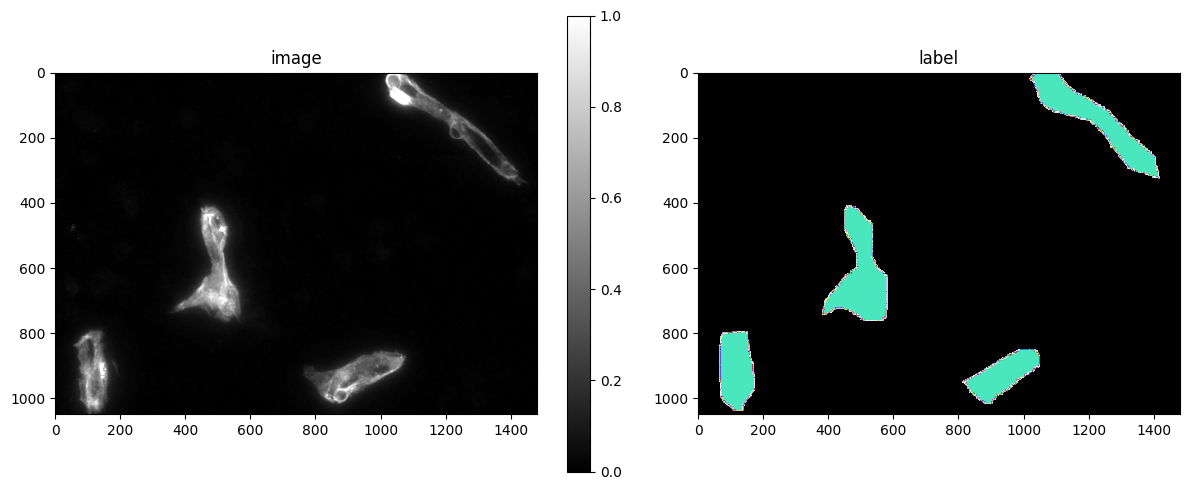

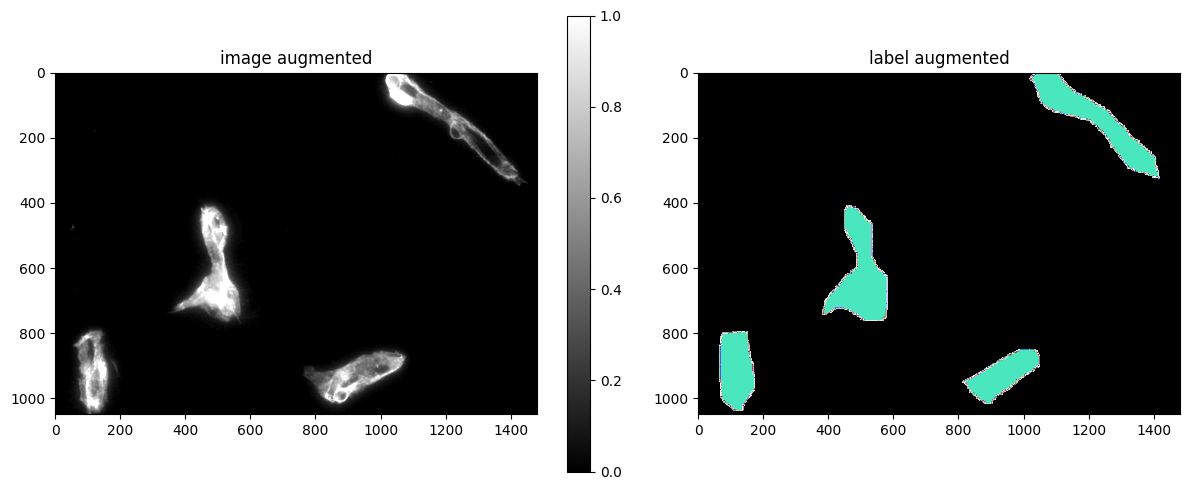

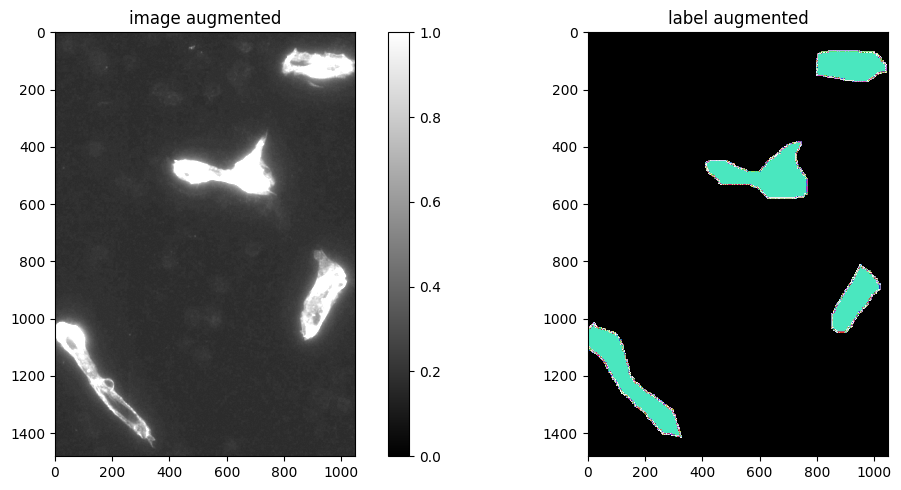

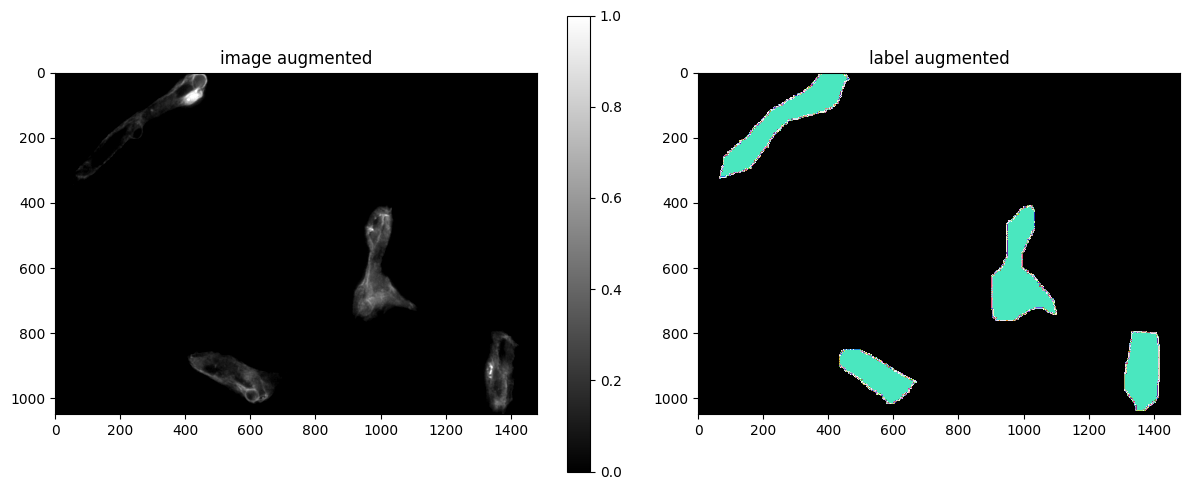

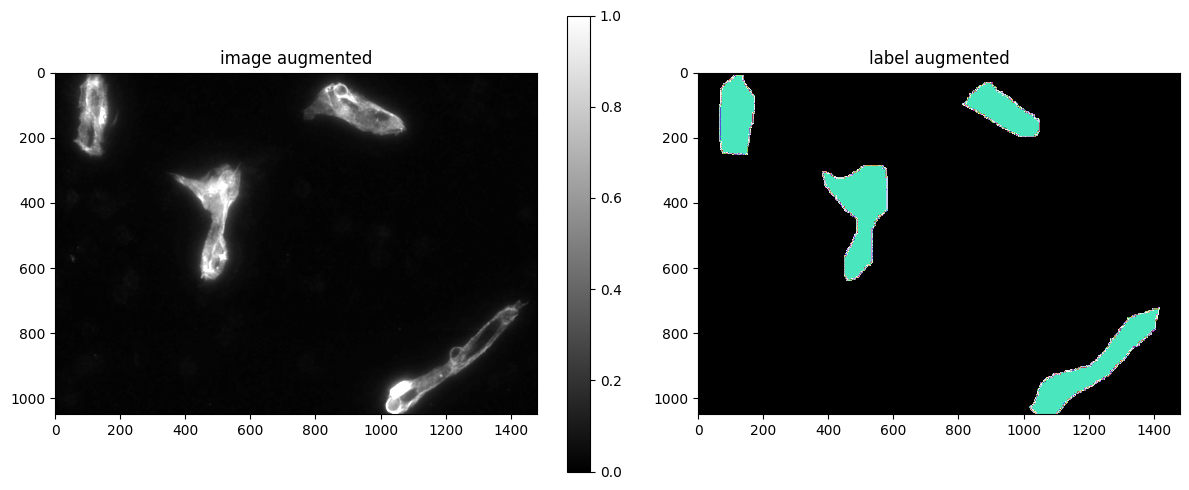

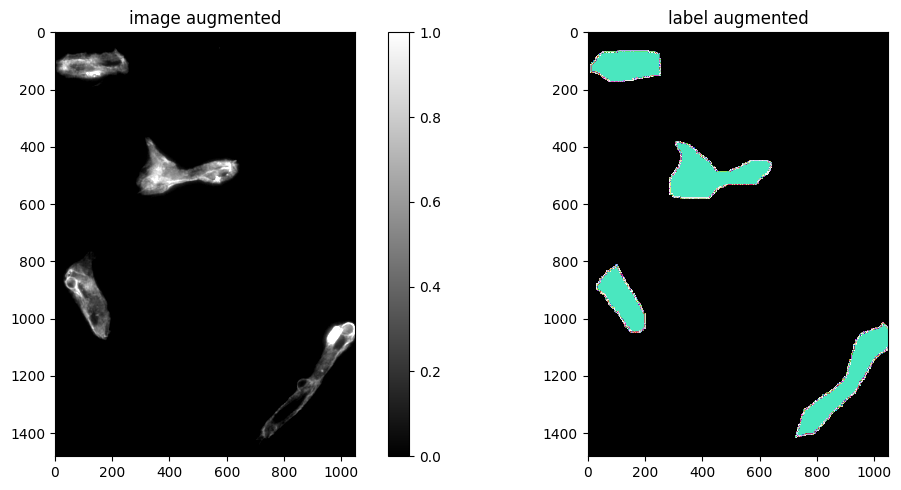

In [21]:
# plot some augmented examples
img, lbl = X[5],Y[5]
plot_img_label(img, lbl)
for _ in range(5):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented", lbl_title="label augmented")

In [24]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter, epochs=100, steps_per_epoch=100)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/100
100/100 [==============================] - 72s 718ms/step - loss: 1.6474 - prob_loss: 0.0655 - dist_loss: 7.9093 - prob_kld: 0.0178 - dist_relevant_mae: 7.9079 - dist_relevant_mse: 209.3910 - dist_dist_iou_metric: 0.6495 - val_loss: 1.9025 - val_prob_loss: 0.0517 - val_dist_loss: 9.2541 - val_prob_kld: 0.0235 - val_dist_relevant_mae: 9.2529 - val_dist_relevant_mse: 248.7922 - val_dist_dist_iou_metric: 0.6034

Epoch 2/100
100/100 [==============================] - 65s 655ms/step - loss: 1.6594 - prob_loss: 0.0652 - dist_lo

Epoch 17/100
100/100 [==============================] - 61s 608ms/step - loss: 1.5441 - prob_loss: 0.0600 - dist_loss: 7.4206 - prob_kld: 0.0143 - dist_relevant_mae: 7.4194 - dist_relevant_mse: 193.9944 - dist_dist_iou_metric: 0.6486 - val_loss: 1.4308 - val_prob_loss: 0.0425 - val_dist_loss: 6.9417 - val_prob_kld: 0.0143 - val_dist_relevant_mae: 6.9403 - val_dist_relevant_mse: 100.5655 - val_dist_dist_iou_metric: 0.6762
Epoch 18/100
100/100 [==============================] - 62s 620ms/step - loss: 1.6896 - prob_loss: 0.0693 - dist_loss: 8.1015 - prob_kld: 0.0226 - dist_relevant_mae: 8.1001 - dist_relevant_mse: 216.2470 - dist_dist_iou_metric: 0.6394 - val_loss: 1.5993 - val_prob_loss: 0.0429 - val_dist_loss: 7.7819 - val_prob_kld: 0.0147 - val_dist_relevant_mae: 7.7804 - val_dist_relevant_mse: 145.8154 - val_dist_dist_iou_metric: 0.6642
Epoch 19/100
100/100 [==============================] - 61s 609ms/step - loss: 1.5584 - prob_loss: 0.0619 - dist_loss: 7.4826 - prob_kld: 0.0154 - dis

100/100 [==============================] - 59s 595ms/step - loss: 1.5328 - prob_loss: 0.0639 - dist_loss: 7.3444 - prob_kld: 0.0160 - dist_relevant_mae: 7.3431 - dist_relevant_mse: 190.6010 - dist_dist_iou_metric: 0.6581 - val_loss: 1.6249 - val_prob_loss: 0.0473 - val_dist_loss: 7.8884 - val_prob_kld: 0.0191 - val_dist_relevant_mae: 7.8871 - val_dist_relevant_mse: 180.0933 - val_dist_dist_iou_metric: 0.6493
Epoch 37/100
100/100 [==============================] - 60s 598ms/step - loss: 1.5489 - prob_loss: 0.0650 - dist_loss: 7.4197 - prob_kld: 0.0165 - dist_relevant_mae: 7.4185 - dist_relevant_mse: 185.5268 - dist_dist_iou_metric: 0.6658 - val_loss: 1.9550 - val_prob_loss: 0.0473 - val_dist_loss: 9.5385 - val_prob_kld: 0.0191 - val_dist_relevant_mae: 9.5373 - val_dist_relevant_mse: 217.1781 - val_dist_dist_iou_metric: 0.6068
Epoch 38/100
100/100 [==============================] - 60s 600ms/step - loss: 1.6001 - prob_loss: 0.0668 - dist_loss: 7.6665 - prob_kld: 0.0157 - dist_relevant_ma

100/100 [==============================] - 60s 599ms/step - loss: 1.4468 - prob_loss: 0.0614 - dist_loss: 6.9267 - prob_kld: 0.0135 - dist_relevant_mae: 6.9255 - dist_relevant_mse: 181.8577 - dist_dist_iou_metric: 0.6757 - val_loss: 1.4756 - val_prob_loss: 0.0437 - val_dist_loss: 7.1597 - val_prob_kld: 0.0155 - val_dist_relevant_mae: 7.1585 - val_dist_relevant_mse: 143.2955 - val_dist_dist_iou_metric: 0.6545
Epoch 56/100
100/100 [==============================] - 60s 596ms/step - loss: 1.2922 - prob_loss: 0.0589 - dist_loss: 6.1662 - prob_kld: 0.0128 - dist_relevant_mae: 6.1650 - dist_relevant_mse: 141.8238 - dist_dist_iou_metric: 0.6975 - val_loss: 1.7520 - val_prob_loss: 0.0443 - val_dist_loss: 8.5385 - val_prob_kld: 0.0162 - val_dist_relevant_mae: 8.5372 - val_dist_relevant_mse: 164.0697 - val_dist_dist_iou_metric: 0.6416
Epoch 57/100
100/100 [==============================] - 60s 596ms/step - loss: 1.3957 - prob_loss: 0.0632 - dist_loss: 6.6625 - prob_kld: 0.0141 - dist_relevant_ma

100/100 [==============================] - 59s 590ms/step - loss: 1.3076 - prob_loss: 0.0593 - dist_loss: 6.2415 - prob_kld: 0.0126 - dist_relevant_mae: 6.2403 - dist_relevant_mse: 141.6242 - dist_dist_iou_metric: 0.7013 - val_loss: 1.7509 - val_prob_loss: 0.0463 - val_dist_loss: 8.5229 - val_prob_kld: 0.0181 - val_dist_relevant_mae: 8.5217 - val_dist_relevant_mse: 195.6579 - val_dist_dist_iou_metric: 0.6384
Epoch 75/100
100/100 [==============================] - 59s 588ms/step - loss: 1.2889 - prob_loss: 0.0572 - dist_loss: 6.1585 - prob_kld: 0.0126 - dist_relevant_mae: 6.1573 - dist_relevant_mse: 147.6185 - dist_dist_iou_metric: 0.6986 - val_loss: 1.6486 - val_prob_loss: 0.0457 - val_dist_loss: 8.0144 - val_prob_kld: 0.0175 - val_dist_relevant_mae: 8.0132 - val_dist_relevant_mse: 164.8940 - val_dist_dist_iou_metric: 0.6498
Epoch 76/100
100/100 [==============================] - 59s 590ms/step - loss: 1.2759 - prob_loss: 0.0589 - dist_loss: 6.0850 - prob_kld: 0.0121 - dist_relevant_ma

100/100 [==============================] - 59s 590ms/step - loss: 1.2907 - prob_loss: 0.0611 - dist_loss: 6.1477 - prob_kld: 0.0133 - dist_relevant_mae: 6.1464 - dist_relevant_mse: 148.0526 - dist_dist_iou_metric: 0.7061 - val_loss: 1.2556 - val_prob_loss: 0.0412 - val_dist_loss: 6.0719 - val_prob_kld: 0.0131 - val_dist_relevant_mae: 6.0708 - val_dist_relevant_mse: 94.0411 - val_dist_dist_iou_metric: 0.6737
Epoch 94/100
100/100 [==============================] - 59s 588ms/step - loss: 1.2607 - prob_loss: 0.0599 - dist_loss: 6.0037 - prob_kld: 0.0128 - dist_relevant_mae: 6.0024 - dist_relevant_mse: 137.9212 - dist_dist_iou_metric: 0.7050 - val_loss: 1.4886 - val_prob_loss: 0.0425 - val_dist_loss: 7.2307 - val_prob_kld: 0.0143 - val_dist_relevant_mae: 7.2295 - val_dist_relevant_mse: 113.9168 - val_dist_dist_iou_metric: 0.6669
Epoch 95/100
100/100 [==============================] - 59s 585ms/step - loss: 1.2815 - prob_loss: 0.0573 - dist_loss: 6.1213 - prob_kld: 0.0123 - dist_relevant_mae

In [25]:
#Optimize the thresolds using the trained model
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:02<00:00,  7.21it/s, 0.353 -> 0.000]


Using optimized values: prob_thresh=0.354146, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.3541455316015255, 'nms': 0.3}

In [26]:
#Load saved model
my_model = StarDist2D(None, name='ProbeSegCy5-2', basedir='C:/Users/ya-chen.chuang/Documents/QuPath/models')

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.354146, nms_thresh=0.3.


In [27]:
model=my_model

In [28]:
#Predict on validation images
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 3/3 [00:02<00:00,  1.36it/s]


100%|██████████| 14/14 [00:01<00:00, 11.39it/s]


DatasetMatching(criterion='iou', thresh=0.5, fp=38, tp=0, fn=3, precision=0, recall=0, accuracy=0, f1=0, n_true=3, n_pred=38, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False)

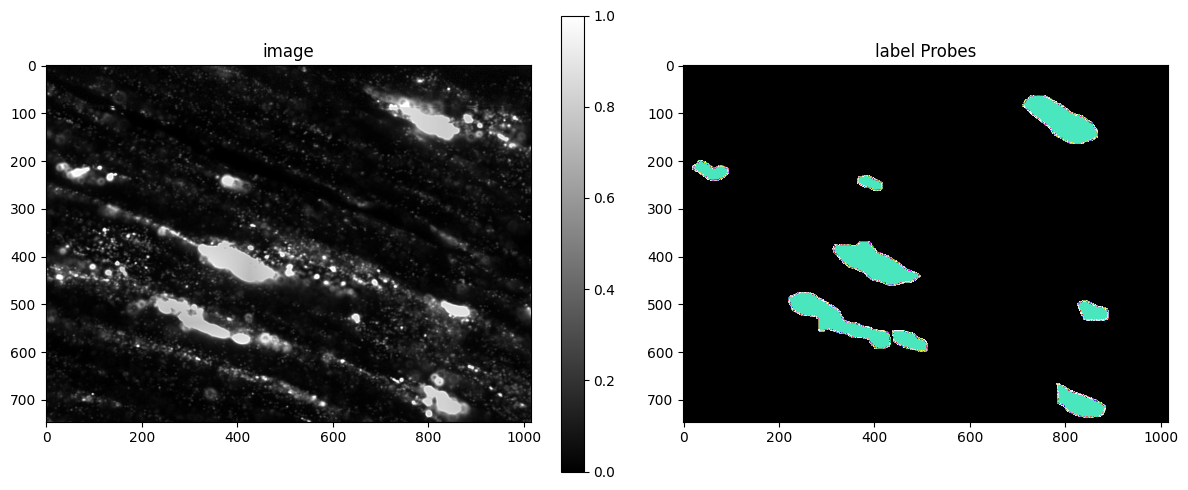

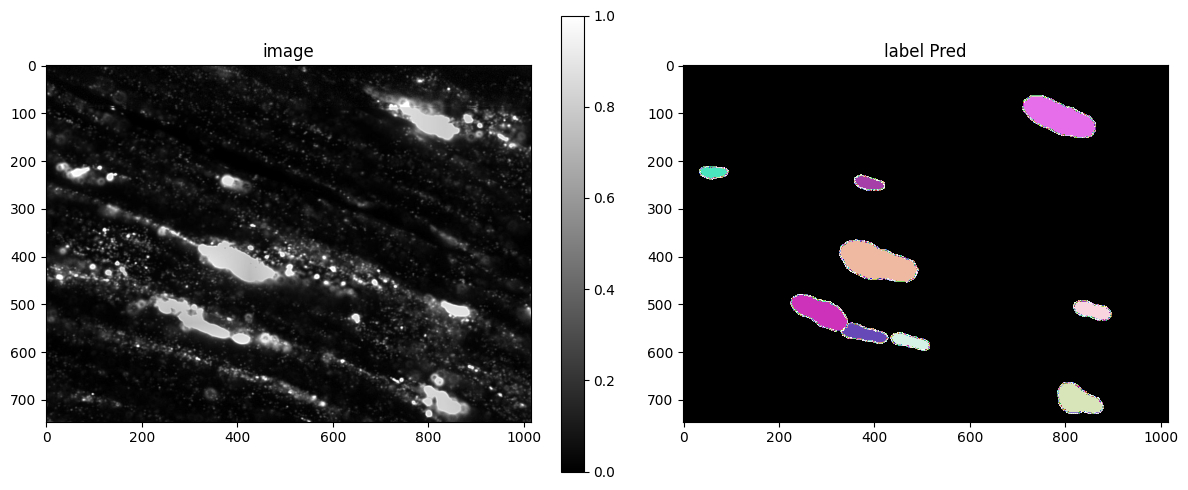

In [29]:
#PLot original labels and predcitions
plot_img_label(X_val[0],Y_val[0], lbl_title="label Probes")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0]
# taus = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

stats[taus.index(0.5)]

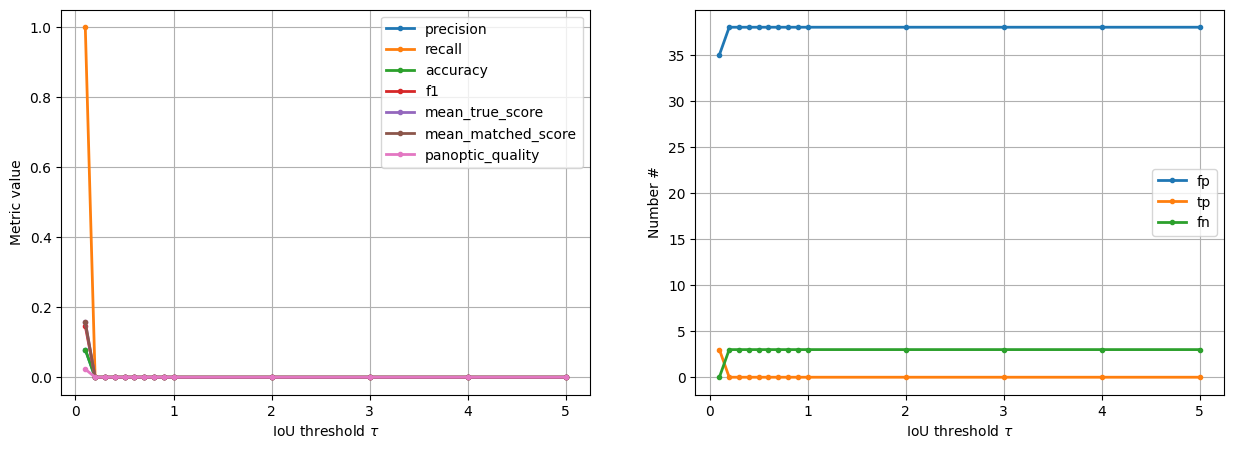

In [30]:
#Plot key metrics 
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();


model = StarDist2D(conf, 'ProbeSegCy5', basedir='models')
model.export_TF()

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.425072, nms_thresh=0.3.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: C:\Users\YA-CHE~1.CHU\AppData\Local\Temp\tmp3j72xgjb\model\saved_model.pb
